# Installs and Imports

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.5 MB/s 


In [2]:
# google drive
from google.colab import drive
drive.mount('/content/drive')

from tqdm import tqdm
import yaml
import pickle
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.engine.base_layer import Layer
from tensorflow.keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects

import warnings
warnings.filterwarnings("ignore")

from drive.MyDrive.Kaggle.Imputation_062022.Final import functions
from drive.MyDrive.Kaggle.Imputation_062022.Final import MLP

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Environment Configs
- Here I am loading the config file, setting global seeds and checking for TPU to determine the proper strategy

In [3]:
with open('drive/MyDrive/Kaggle/Imputation_062022/Final/config.YAML', 'r') as f:
    config = yaml.load(f)

functions.set_seed(config['SEED'])

In [4]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


# Data Loading

In [5]:
data = pd.read_csv(config['PATH'] + 'Final/data.csv', index_col='row_id')

cont_feats = data.select_dtypes('float').columns
cat_feats = data.select_dtypes('int').columns
col_list, F1, F2, F3, F4, missing_cols = functions.get_lists(data)

F4data = data[F4]

# EDA

## Basic Exploration
- take a peak
- data types
- missing values
- basic stats (mean, IQR, std, min, max)
- unique values

In [ ]:
data.head().T

row_id,0,1,2,3,4
F_1_0,-0.354591,1.380940,0.256023,-0.728420,0.590212
F_1_1,-0.464038,-0.499626,-1.059874,-2.432399,-0.066127
F_1_2,2.304115,-0.418548,NaN,-2.453602,0.468009
F_1_3,0.734486,1.911725,0.345678,-0.020509,-1.096038
F_1_4,1.696395,-0.826130,1.513814,0.333397,0.119399
F_1_5,0.136285,-1.715371,1.243864,0.086049,-1.809710
F_1_6,-0.518344,-0.577091,-0.509648,-1.787601,0.466358
F_1_7,0.502640,-1.041486,-0.800481,0.667011,-0.053196
F_1_8,-1.852504,0.596067,-0.115945,0.761564,-0.580320
F_1_9,-0.500665,-0.363425,0.595777,-2.217847,-1.143500


In [ ]:
stats = data.describe().T
stats['dtype'] = data.dtypes.values
stats['missing_values'] = data.isnull().sum().T
stats['unique_values'] = data.nunique()
stats

,count,mean,std,min,25%,50%,75%,max,dtype,missing_values,unique_values
F_1_0,981603.0,-0.000687,1.000784,-4.664447,-0.674667,-0.000769,0.673181,5.039177,float64,18397,859226
F_1_1,981784.0,0.002091,0.999878,-4.790594,-0.672284,0.002049,0.675997,5.042807,float64,18216,858873
F_1_2,981992.0,0.000551,0.999825,-4.870645,-0.673783,0.001386,0.674490,5.130025,float64,18008,859449
F_1_3,981750.0,0.000982,0.999847,-5.053023,-0.672211,0.000370,0.674852,5.462472,float64,18250,858808
F_1_4,981678.0,0.002437,1.001151,-5.363454,-0.672326,0.002733,0.676588,4.856916,float64,18322,859416
F_1_5,981911.0,0.000635,0.999927,-5.508223,-0.673884,0.000276,0.675951,4.960724,float64,18089,859725
F_1_6,981867.0,-0.000124,1.000427,-5.199170,-0.674834,0.000814,0.673983,4.957977,float64,18133,859020
F_1_7,981872.0,-0.063857,0.725986,-6.990302,-0.500305,0.000578,0.444337,2.527570,float64,18128,813274
F_1_8,981838.0,-0.000014,1.000715,-4.566593,-0.674006,-0.000047,0.674295,4.886075,float64,18162,859112
F_1_9,981751.0,0.000451,1.000194,-4.997549,-0.673513,0.001118,0.675575,4.788579,float64,18249,859000


In [ ]:
data.duplicated().sum()

0

### Basic Exploration Summary
- No duplicates
- Three groups of continuous data (floats), one group of discrete (integers)
- Two of the cont. groups are standardized ie. they have a mean ~0 and std ~1
- The discrete group does not contain missing values

## Distributions
- Now we will analyze the distribution of the data using histograms and boxplots for continuous data and bar charts for discrete. 
- We will also look into the distribution of the missing values using the missing matrix from the library missingno. 
- Lastly, we will also look at the correlation heatmap of the features to determine if there are linear relationships between any features.

### Histograms

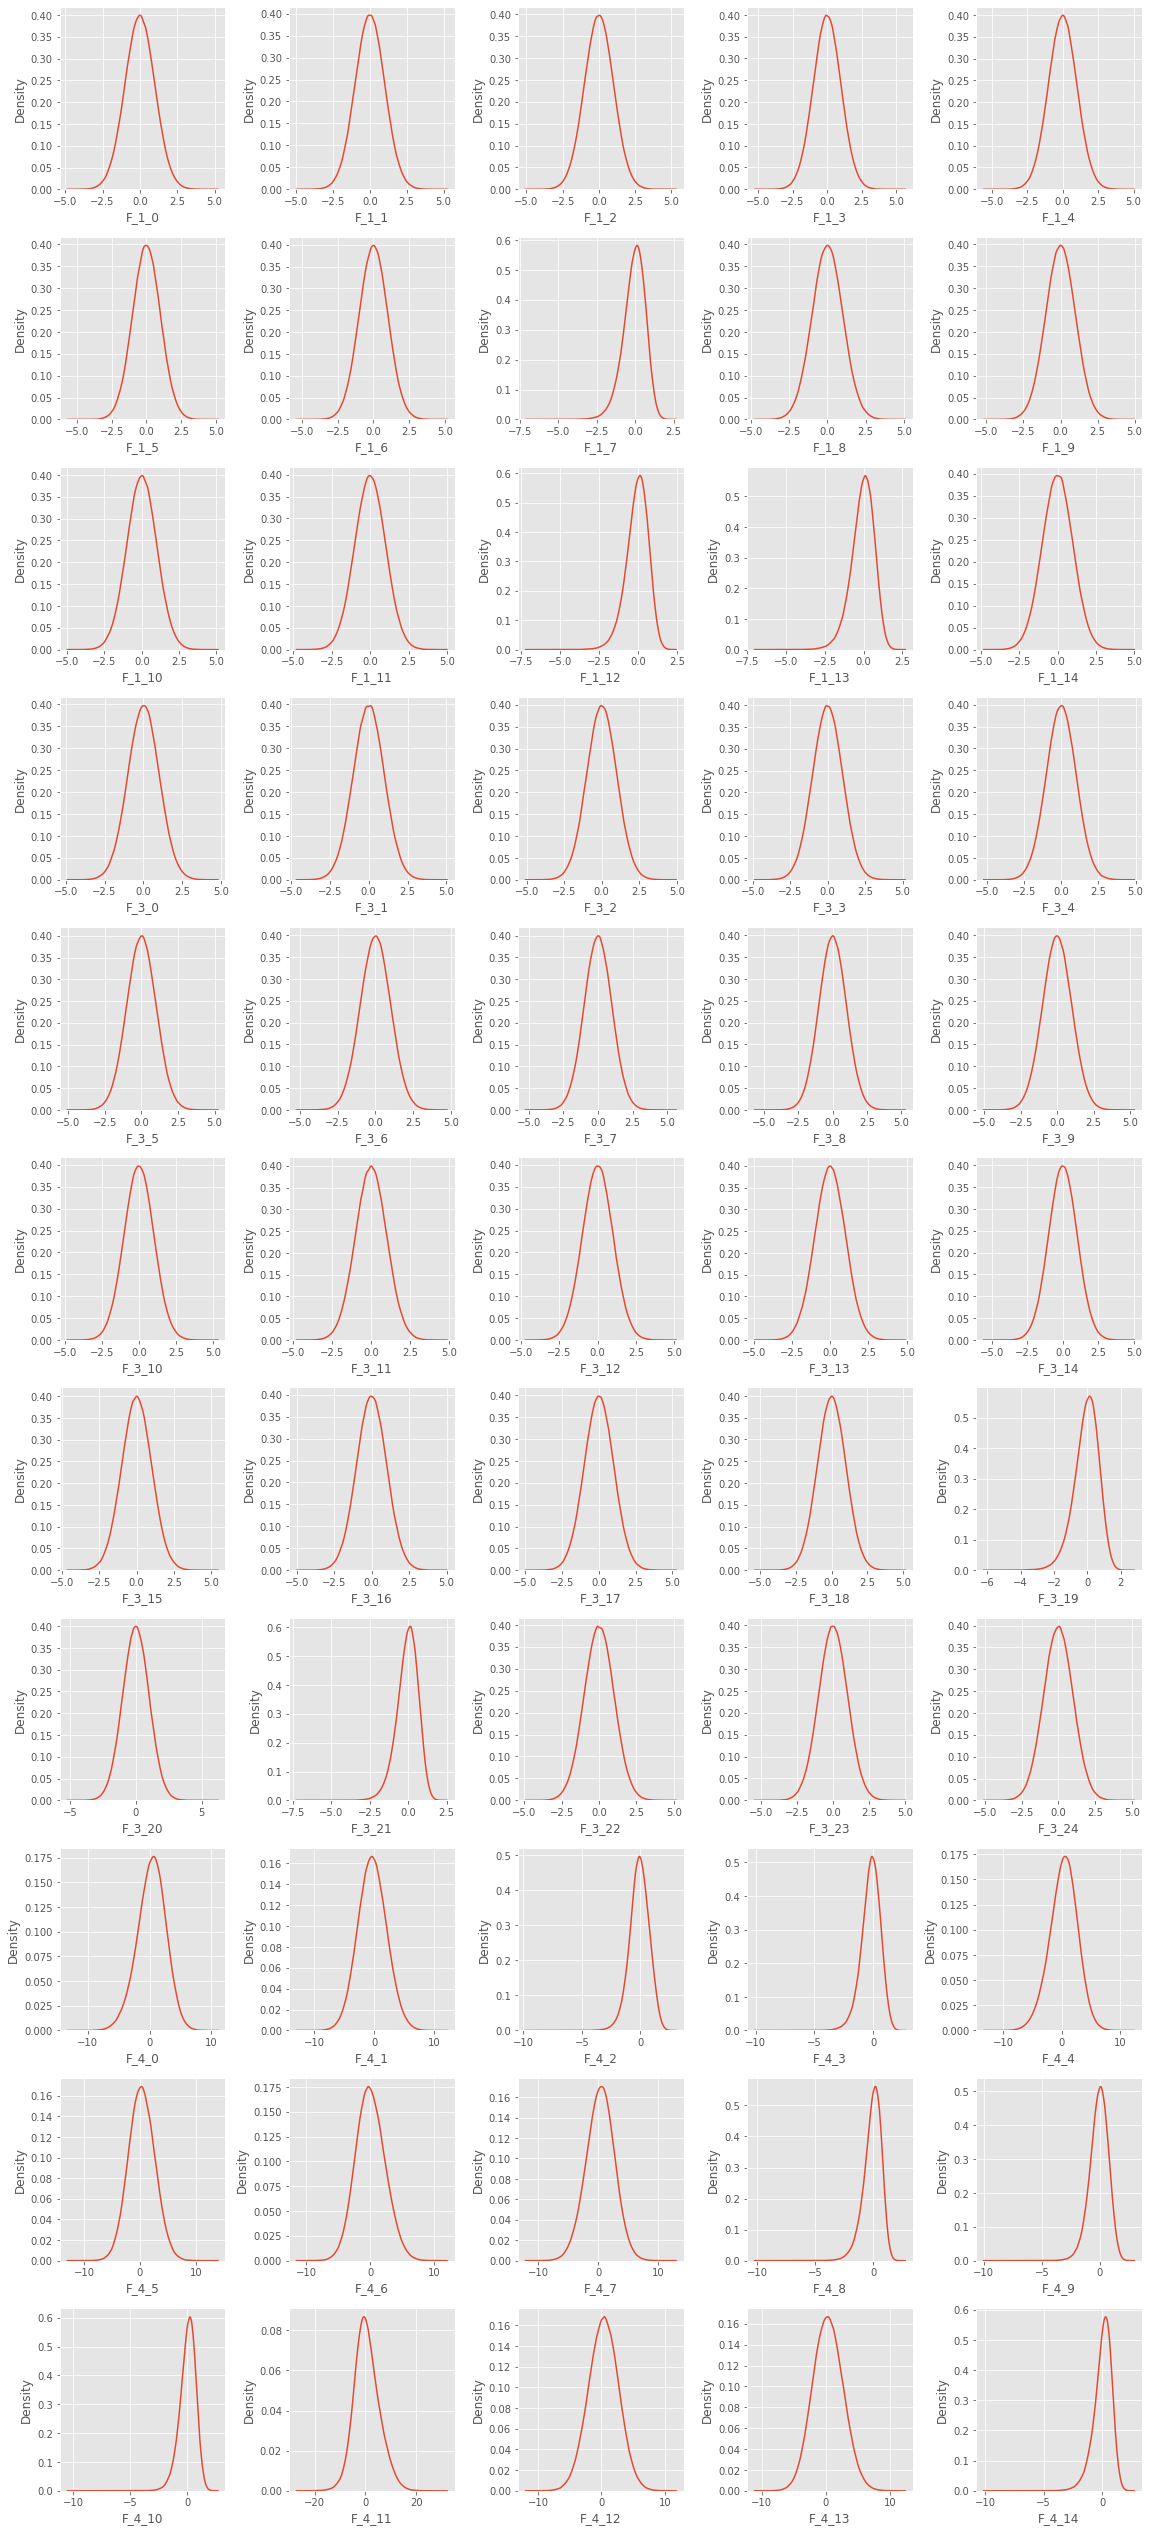

In [ ]:
functions.clf_plot_distributions(data, cont_feats, hue='target', ncols=5, method='hist')

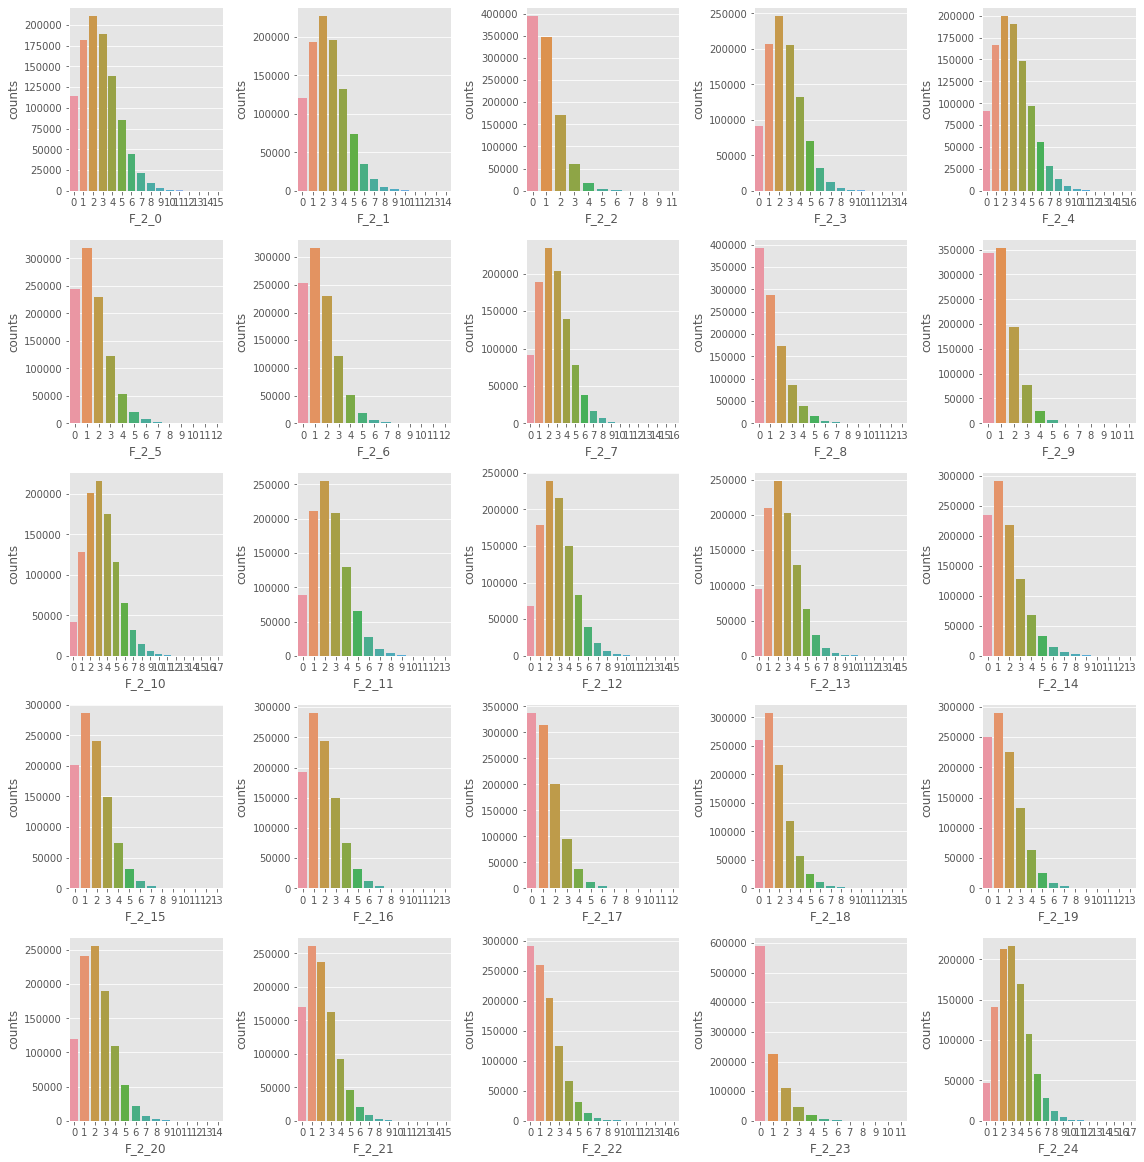

In [ ]:
functions.clf_plot_distributions(data, F2, ncols=5, method='bar')

### Box plots

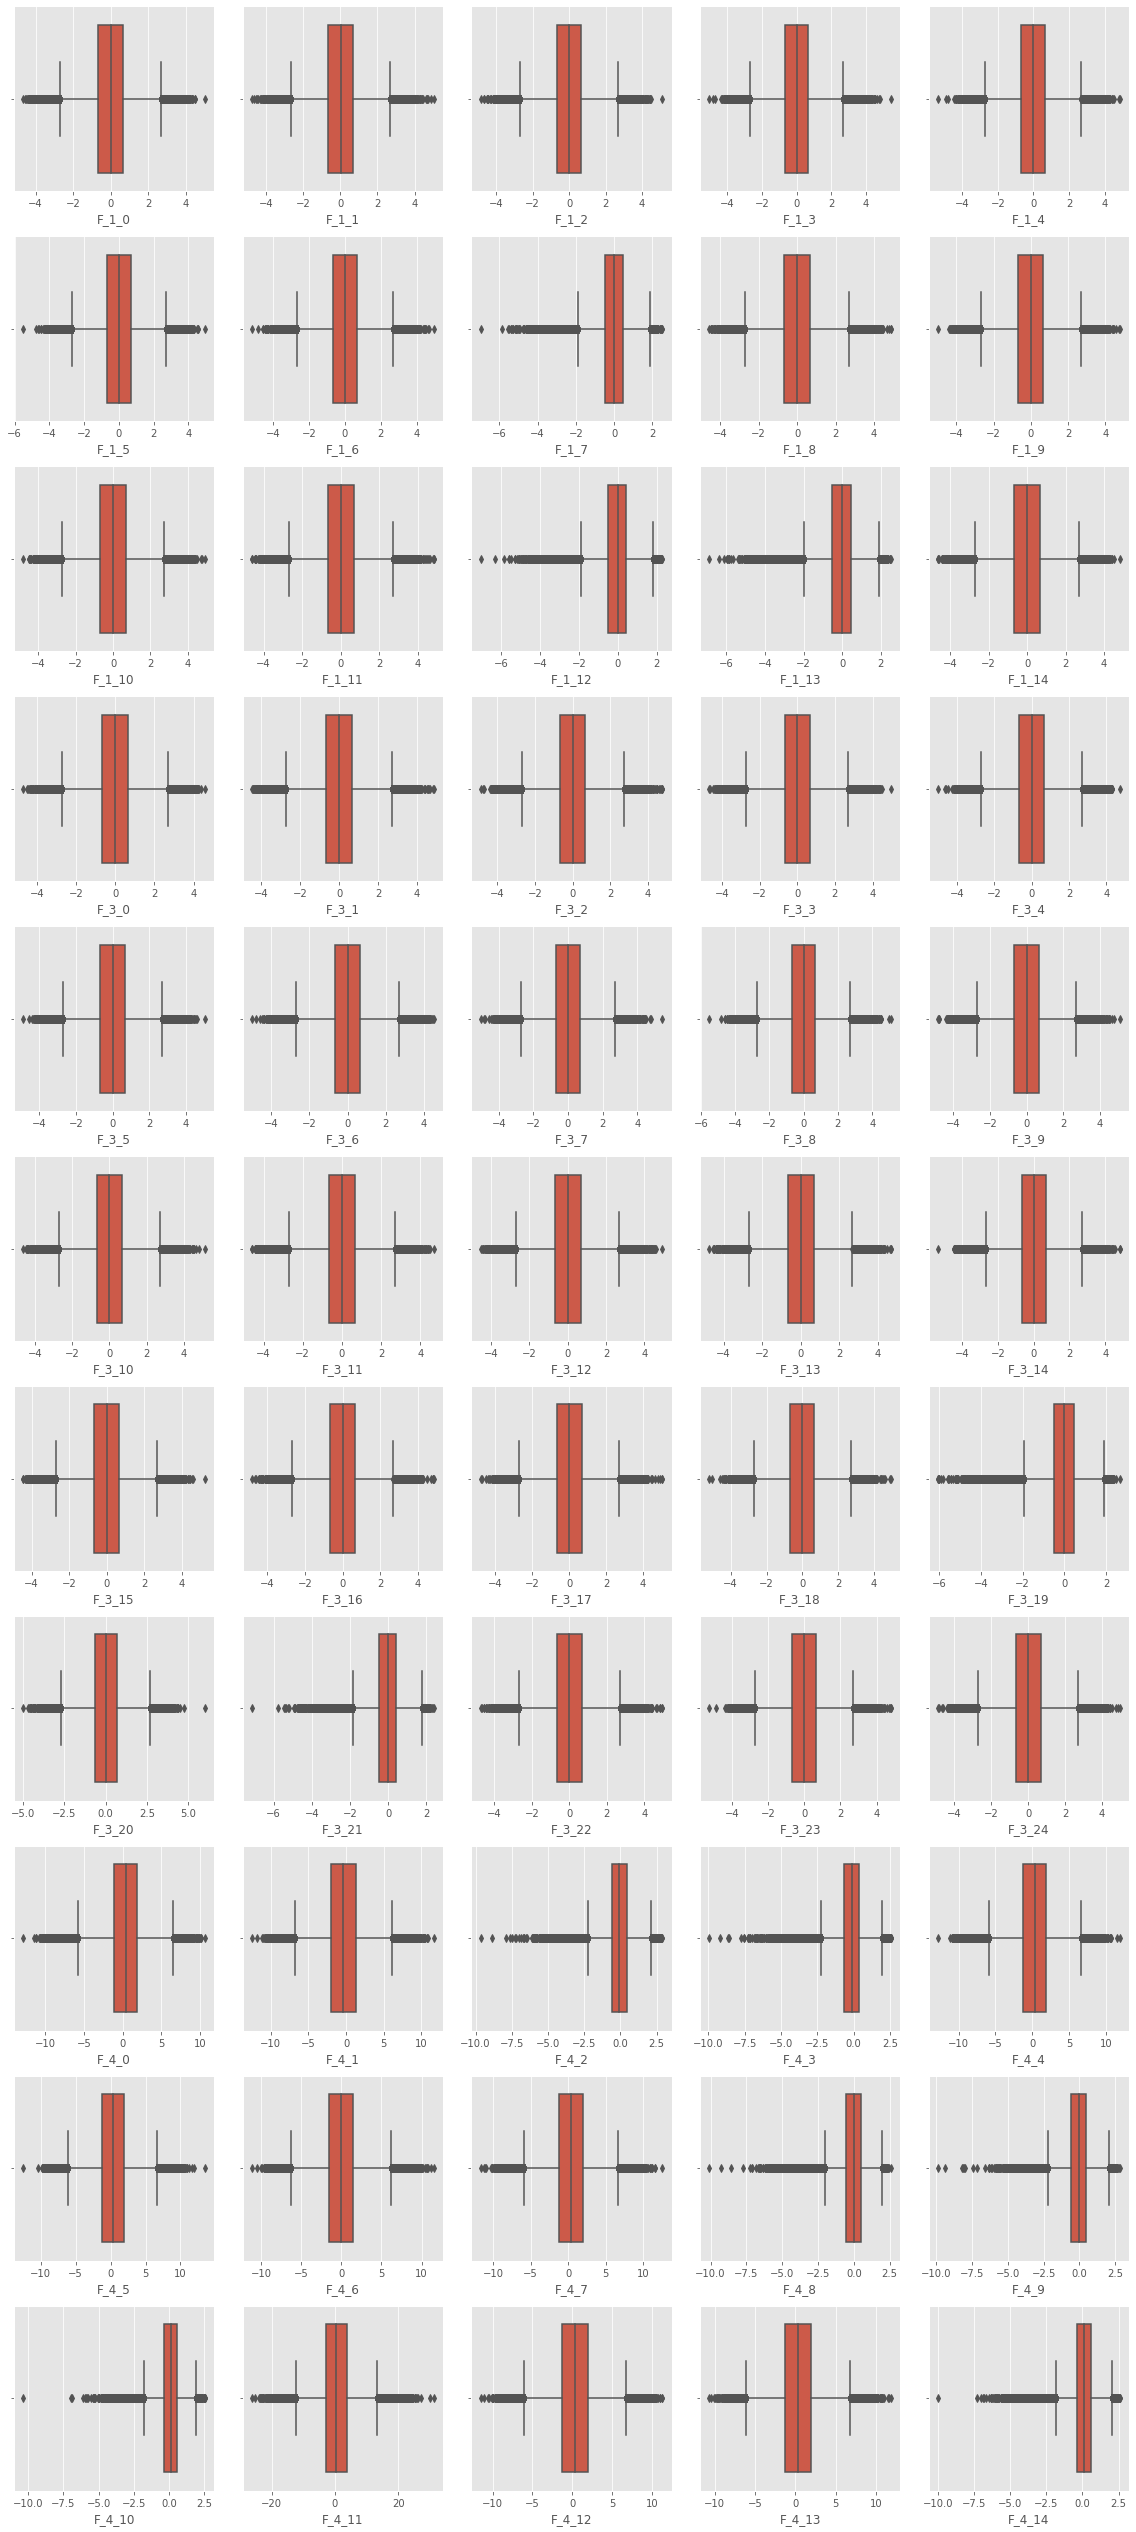

In [ ]:
functions.clf_plot_distributions(data, features=F1+F3+F4, ncols=5, method='box')

- All continuous features follow a normal-ish distribution, some of them skewed. We may have to apply a power transformation.
- There are outliers in the continuous data, especially the F_4's.
- The discrete data may belong to Poisson distribution

### Correlation Heat Maps

Text(0.5, 1.0, 'Correlation Heat Map for All Features')

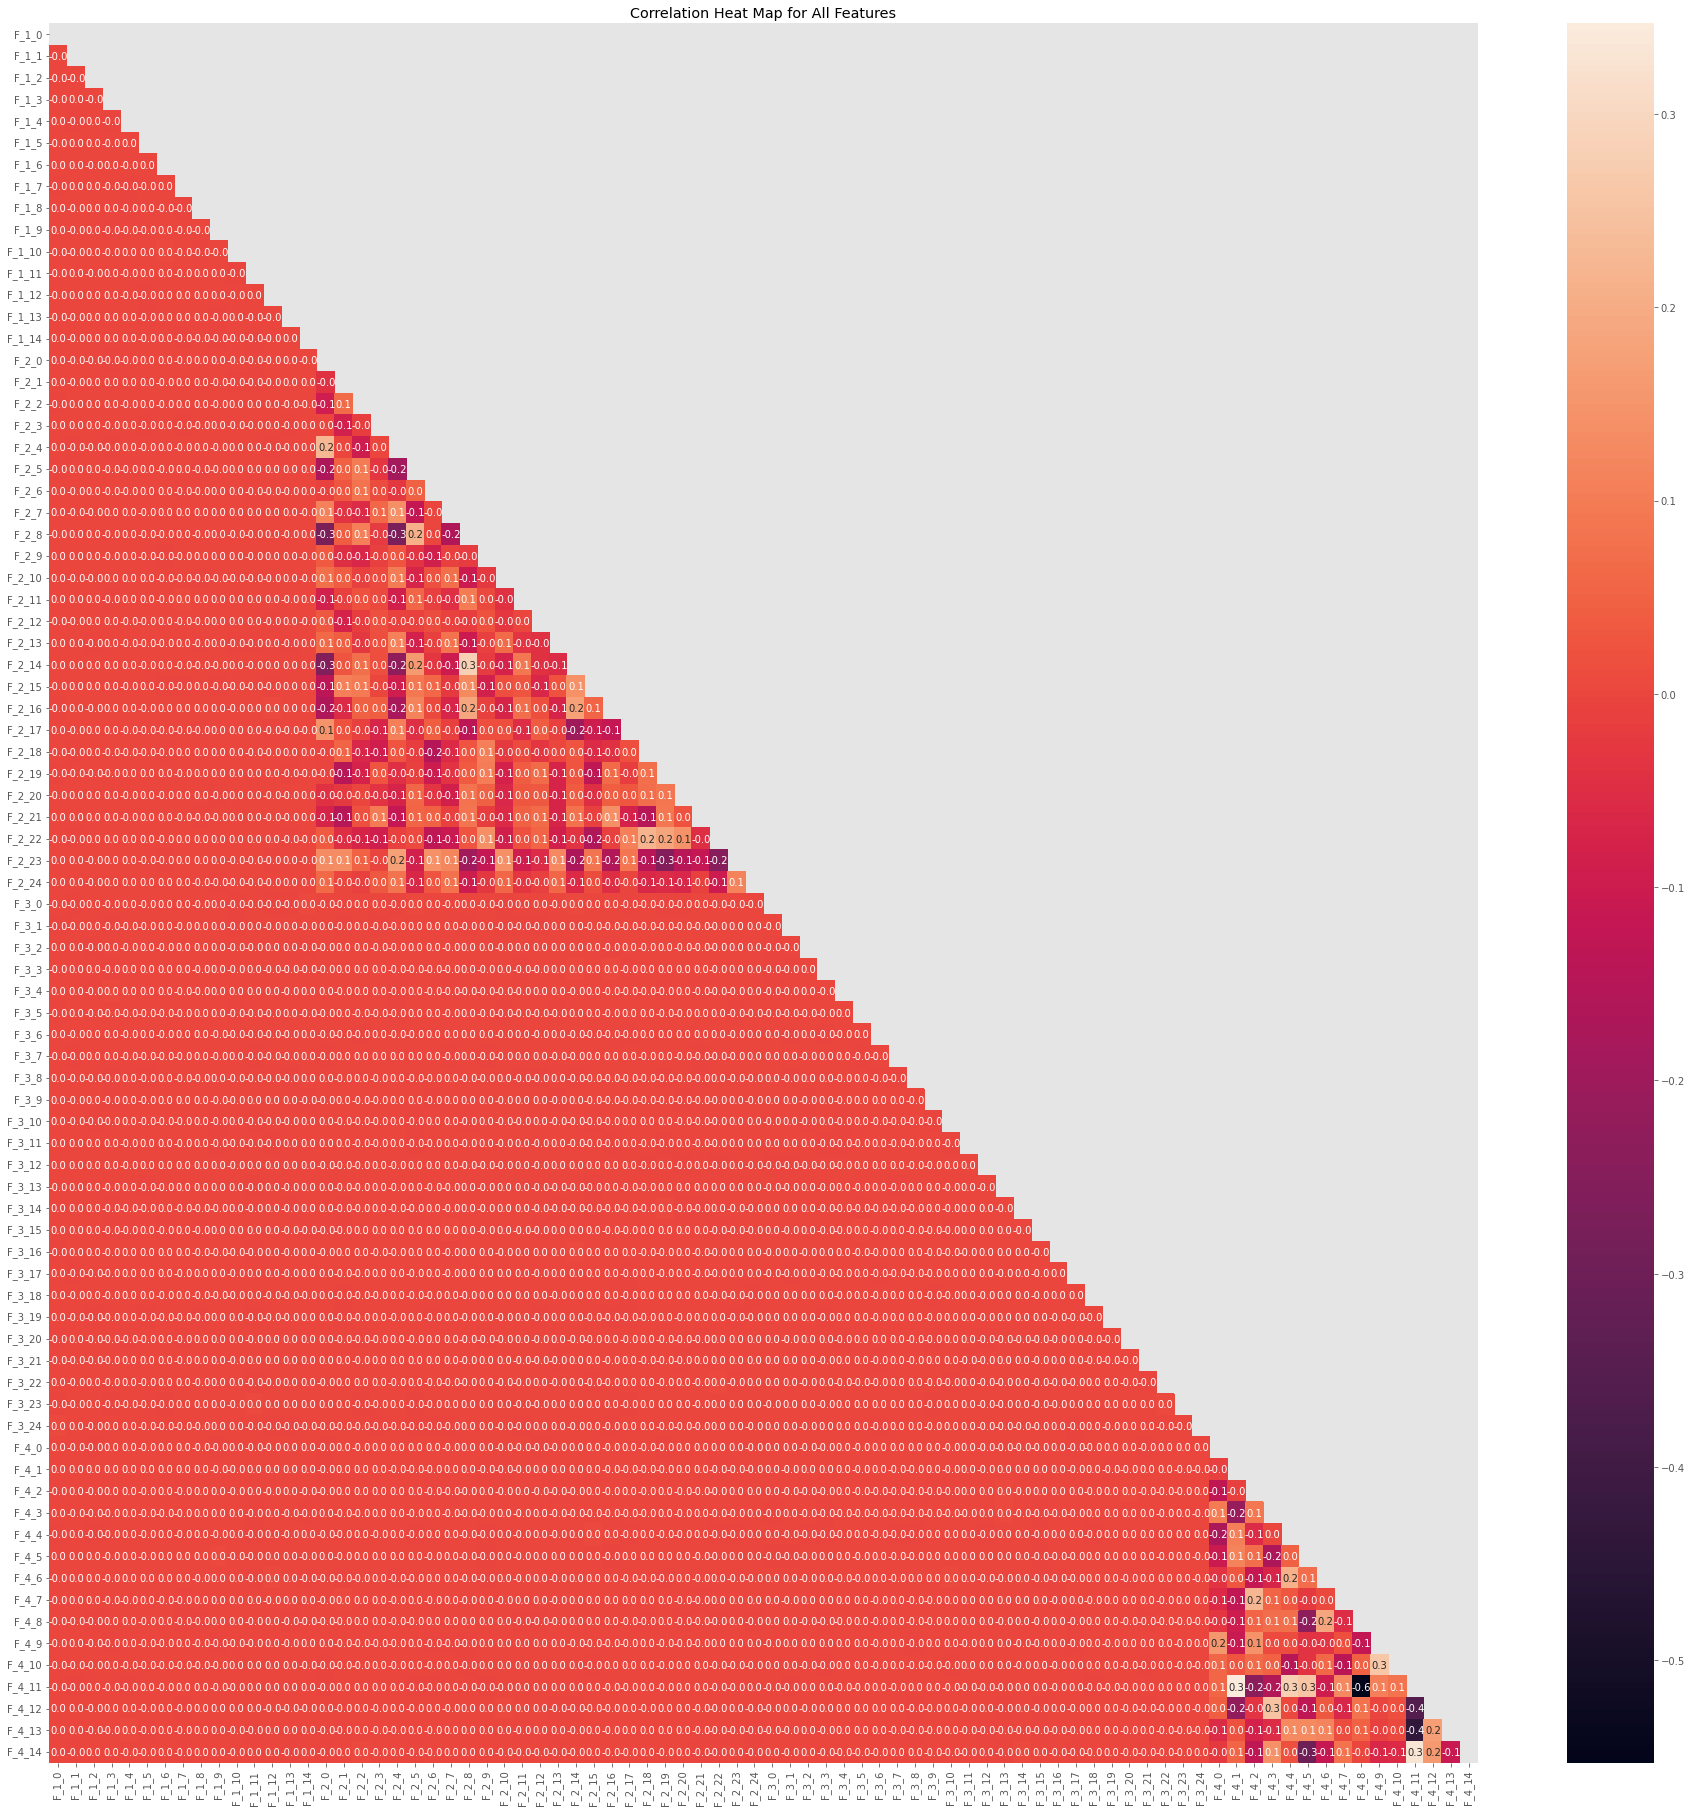

In [ ]:
corr = data.corr()
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize=(32, 32))
sns.heatmap(corr,  xticklabels=corr.columns, yticklabels=corr.columns, annot=True, mask=matrix, ax=ax, fmt='.1f');
ax.set_title('Correlation Heat Map for All Features')

- The only correlation present is between features in feature groups F_2 and F_4

### Missing Values

In [ ]:
na_sums = data.isnull().sum(axis=1)
data['n_missing'] = na_sums
F4_missing = data[F4].isnull().sum(axis=1)
data['F4_missing'] =F4_missing

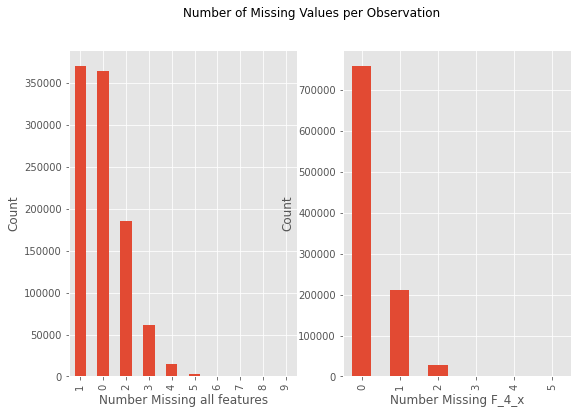

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
data['n_missing'].value_counts().plot(ax=ax1, kind='bar', xlabel='Number Missing all features', ylabel='Count')
data['F4_missing'].value_counts().plot(ax=ax2, kind='bar', xlabel='Number Missing F_4_x', ylabel='Count')
plt.suptitle('Number of Missing Values per Observation')
plt.show()

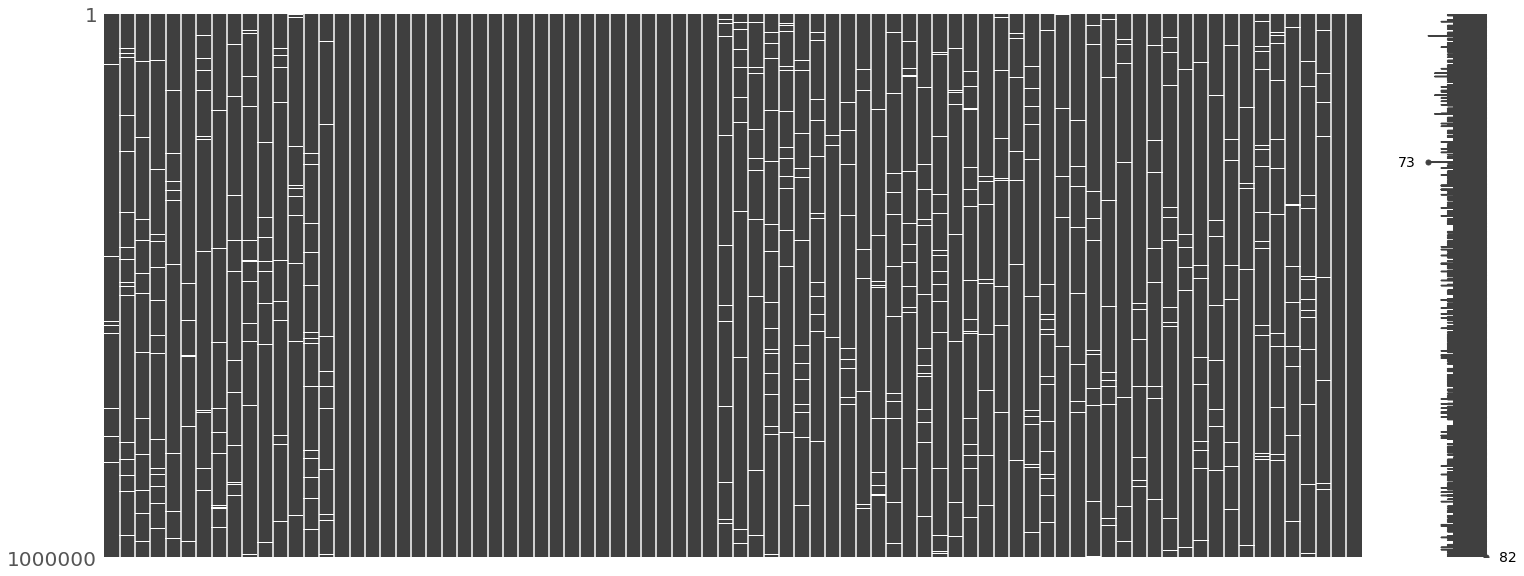

In [ ]:
msno.matrix(data)

## Summary
- Due to the independance and standardization of F_1 and F_3 the appropriate method is to impute with their means. (Minimizing the derivitive of root mean squared error yields the mean)
- Therefore all efforts shall be focused on F_4
- Removing outliers in F_4 may be necessary
- F_2 will need some form of power transformation if we are to use it
- Missing values appear to be spread evenly amonst the continuous features

# Multi-Layer Perceptron
- I used many other models but MLP gave me the best results
- It has five heads, each head takes an output of the inuput node (64 nodes). The heads are two dense layers deep (32=>16), all their outputs are added together and normalized.
- This output goes through five blocks of skip connections consisting of two dense layers (32=>16) with an add layer following.
- The skip connection happens at the add layers. They pas their output to the next dense layer, as well as the next skip connection
- I used Mish as the activator, AdamW as the optimizer and ReduceOnPlateau for a callback

In [6]:
# %%time
data_imputed = pd.DataFrame() 
loss_per_feature={}
history_feats = {}

# prescale and impute data to speed up training
scaler = StandardScaler()
si = SimpleImputer(strategy='mean')
new_df = si.fit_transform(F4data[F4].copy())
new_df = pd.DataFrame(scaler.fit_transform(new_df), columns=F4, index=F4data.index)

# Iterate over the columns that contain Nan values
for idx, col in tqdm(enumerate(F4)):
    print(col)
    predictions=[]
    validation_loss=[]
    training_loss = []
    history_per = {}

    # Mask to access not_null part of the current column
    not_null = ~F4data[col].isnull()
    
    # Train dataset (includes non-null part of current column)
    train = new_df.loc[not_null, :].drop(columns=col)
    
    # Test dataset (includes null part of current column)
    test = new_df.loc[~not_null, :].drop(columns=col)

    # Split y column out
    y = data[col].loc[not_null]

    # Cross validation type
    kf = KFold(n_splits = config['N_SPLITS'])
    
    # Splitting data to train and validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(train)):

        X_train, X_val = train.iloc[train_idx], train.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx,]
        X_test = test
               

        # Running NN model 
        with strategy.scope():
            model = MLP.nn_model(X_train, lr=config['INITIAL_LR'], dropout_pct=config['DROPOUT_PCT'])
        
        history = model.fit(X_train, y_train, 
                            epochs=config['MAX_EPOCHS'],
                            callbacks=MLP.callbacks(config['LR_FACTOR'], config['LR_PATIENCE'], config['ES_PATIENCE']),
                            validation_data=(X_val, y_val),
                            shuffle=True,
                            verbose=1,
                            batch_size=config['BATCH_SIZE']
        )
        
        # Make an out-of-fold prediction
        y_preds = model.predict(X_test)
        
        # Add y_preds to a list
        predictions.append(y_preds)
        
        # Save loss for current fold
        validation_loss.append(history.history["val_loss"][-1])
        training_loss.append(history.history['loss'][-1])

        # Save history for modelling
        history_per[str(fold)] = history.history

    # Save history for modelling
    history_feats[str(col)] = [item for item in history_per.items()]

    # Caluculate the mean of oof predictions
    mean_values = np.array(predictions).mean(axis = 0)
    
    # Save mean-loss for current feature
    loss_per_feature[col] = np.mean(validation_loss)
    
    # Specifying column to impute
    imputed_feature = data[col].copy()
    
    # Filling missing values
    imputed_feature.loc[~not_null] =  mean_values.ravel()
    
    # Concatenate imputed columns
    data_imputed = pd.concat([data_imputed, imputed_feature],axis = 1)

# Replace columns with imputed columns 
data[F4] = data_imputed[F4]

0it [00:00, ?it/s]

F_4_0


1it [00:00,  1.75it/s]

F_4_1


2it [00:00,  2.17it/s]

F_4_2


3it [00:01,  2.33it/s]

F_4_3


4it [00:01,  2.37it/s]

F_4_4


5it [00:02,  2.43it/s]

F_4_5


6it [00:02,  2.14it/s]

F_4_6


7it [00:03,  2.25it/s]

F_4_7


8it [00:03,  2.33it/s]

F_4_8


9it [00:03,  2.39it/s]

F_4_9


10it [00:04,  2.39it/s]

F_4_10


11it [00:04,  2.42it/s]

F_4_11


12it [00:05,  2.45it/s]

F_4_12


13it [00:05,  2.48it/s]

F_4_13


14it [00:05,  2.46it/s]

F_4_14


15it [00:06,  2.37it/s]


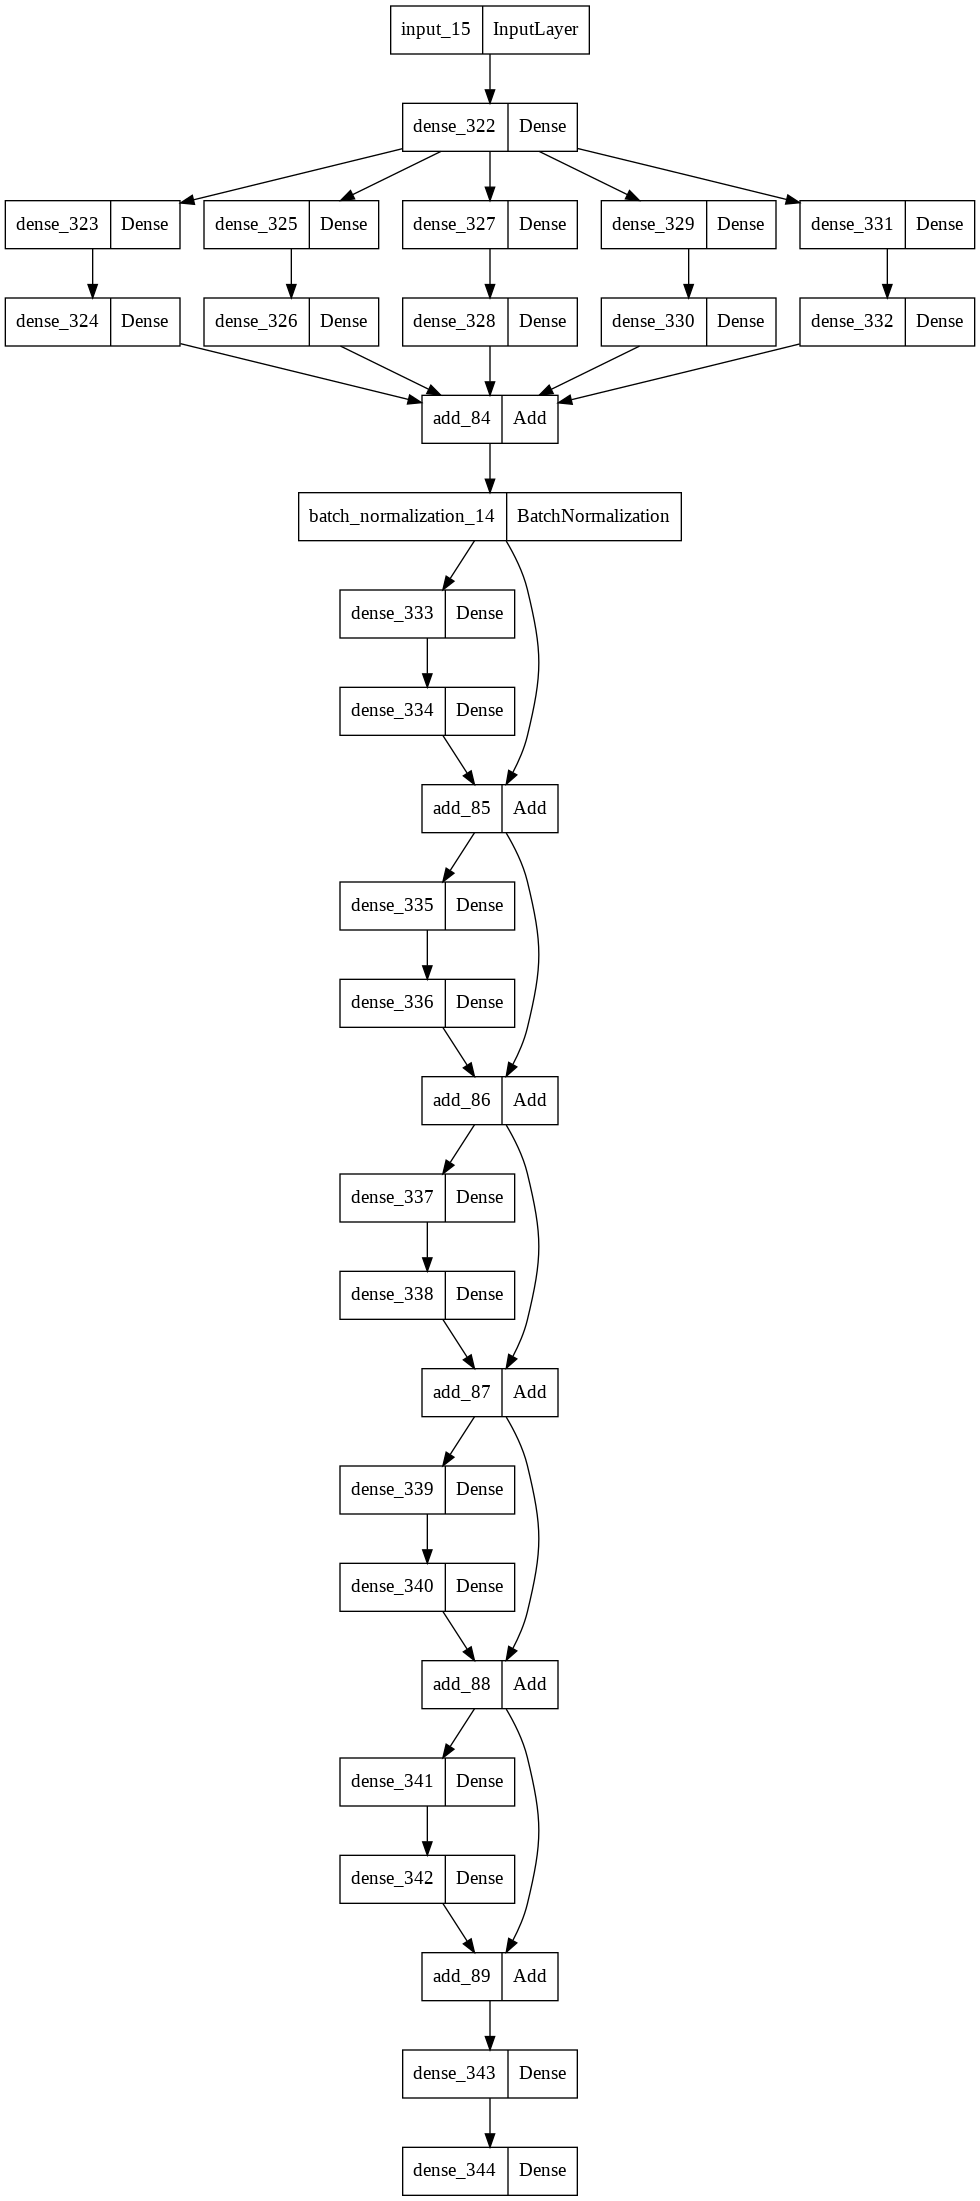

In [7]:
plot_model(model)

In [ ]:
data = pd.DataFrame(SimpleImputer().fit_transform(data), columns=data.columns)
submission = pd.read_csv(config['PATH'] + 'Final/sample_submission.csv', index_col='row-col')
submission = functions.make_submission(data, submission)
submission.to_csv(config['PATH'] + 'sub#1.csv')

# Summary
Overall I am happy with this project. It allowed me to practice a plethora of machine learning techniques and models not to mention brushing up on loss functions and derivitives. If a had even a day extra, I would have trained/predicted based on the number of missing values per row since MLP's can easily use two columns as targets. After looking at some of the final models, I probably would have jumped up at least 50 spots. oh well, next time!